In [6]:
#Import modules
import textacy
import spacy
import scattertext as st
import pandas as pd
from pathlib import Path
from plotnine import *

#change language to german
de = textacy.load_spacy_lang("de_core_news_sm")

In [7]:
#make Python understand gender
m = "male"
f = "female"
Geschlecht = [m,f]

In [8]:
#read dataset (female) from csv file
f_csv = '../KED2022/materials/data/dataset_speeches_f.csv'
df = pd.read_csv(f_csv)

# filter out non-german texts or very short texts
df_sub = df[(df['Sprache'] == 'de') & (df['text'].str.len() > 10)]

# make new column containing all relevant metadata (showing in plot later on)
df_sub['descripton'] = df_sub[['Redner', 'Partei', 'Jahr']].astype(str).agg(', '.join, axis=1)

# sneak peek of dataset
df_sub.head()

,Jahr,Status,Vollständigkeit,Redner,Geschlecht,Funktion,Partei,Partei-Original,Typ,Bemerkung,Sprache,Originalsprache,Ort,Titel,Anrede,Originaltext,Quelle,text,descripton
0,2018,done,vollständig,Doris Leuthard,f,BR,CVP,CVP,Lokal,NaN,de,NaN,Villmergen,NaN,Liebe Mitbürgerinnen und Mitbürger,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,Ich bedanke mich für die Einladung zu Ihrer 1....,"Doris Leuthard, CVP, 2018"
1,2018,done,vollständig,Simonetta Sommaruga,f,BR,SP,SP,Lokal,NaN,de,NaN,Muttenz,Heimat kennt keine Grenzen,"Liebe Festgemeinde,\nSehr geehrter Herr Regier...",NaN,https://www.ejpd.admin.ch/ejpd/de/home/aktuell...,Als ich die Einladung zu dieser Bundesfeier ge...,"Simonetta Sommaruga, SP, 2018"
2,2017,done,vollständig,Doris Leuthard,f,BP,CVP,CVP,BP-Rede,NaN,de,NaN,NaN,NaN,Sehr geehrte Damen und Herren,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Ich hoffe, sie konnten den bisherigen Sommer g...","Doris Leuthard, CVP, 2017"
3,2017,done,vollständig,Simonetta Sommaruga,f,BR,SP,SP,Lokal,NaN,de,fr,Môtiers,"«Val-de-Travers, val ouvert»","Cher Président du Conseil d’Etat,\nCher Présid...",Quel bonheur de célébrer la fête nationale dan...,https://www.ejpd.admin.ch/ejpd/fr/home/aktuell...,"Was für eine Freude, den Nationalfeiertag an e...","Simonetta Sommaruga, SP, 2017"
4,2016,done,vollständig,Doris Leuthard,f,BR,CVP,CVP,Lokal,NaN,de,NaN,Schaffhausen,"Wer entscheidet, muss zuhören!",Sehr geehrter Herr Regierungspräsident (Reto D...,NaN,https://www.admin.ch/gov/de/start/dokumentatio...,"Ich freue mich, heute in Schaffhausen mit Ihne...","Doris Leuthard, CVP, 2016"


In [9]:
#create corpus for female dataset
def get_texts_from_csv(f_csv, text_column):
    """
    Read dataset from a csv file and sequentially stream the rows,
    including metadata.
    """
    
    # read dataframe
    df = pd.read_csv(f_csv)
    
    # keep only documents that have text
    filtered_df = df[df[text_column].notnull()]
    
    # iterate over rows in dataframe
    for idx, row in filtered_df.iterrows():
        
        # read text and join lines (remove hard line-breaks)
        text = row[text_column].replace('\n', ' ')

        # use all columns as metadata, except the column with the actual text
        metadata = row.to_dict()
        del metadata[text_column]

        yield (text, metadata)

f_csv = '../KED2022/materials/data/dataset_speeches_f.csv'
texts = get_texts_from_csv(f_csv, text_column='text')

corpus_speeches_f = textacy.Corpus(de, data=texts)

In [10]:
# define what groups are formed and what terms should be included
# here, groups by year and words are lowercased (incl. stop words)
tokenized_docs, groups = textacy.io.unzip(
        (textacy.extract.utils.terms_to_strings(textacy.extract.words(doc, filter_stops=False), by="lower"),
        doc._.meta["Jahr"])
        for doc in corpus_speeches_f)

# define how to count
# here relative term frequency
vectorizer = textacy.representations.vectorizers.GroupVectorizer(
        tf_type='linear', # absolute term frequency
        dl_type="linear", # normalized by document length
        vocabulary_grps=range(1950, 2019)) # limit to years from 1950 to 2019

# create group-term-matrix with with frequency counts
grp_term_matrix = vectorizer.fit_transform(tokenized_docs, groups)

# create dataframe from matrix
df_terms = pd.DataFrame.sparse.from_spmatrix(grp_term_matrix, index=vectorizer.grps_list, columns=vectorizer.terms_list)
df_terms['year'] = df_terms.index

# change shape of dataframe
df_tidy = df_terms.melt(id_vars='year', var_name="term", value_name="frequency")
df_tidy

/home/nilsos/.local/lib/python3.8/site-packages/textacy/representations/vectorizers.py:673: RuntimeWarning: divide by zero encountered in true_divide


,year,term,frequency
0,1950,-unterhalt,0.00000
1,1951,-unterhalt,0.00000
2,1952,-unterhalt,0.00000
3,1953,-unterhalt,0.00000
4,1954,-unterhalt,0.00000
...,...,...,...
511423,2014,►,0.00000
511424,2015,►,0.00000
511425,2016,►,0.00000
511426,2017,►,0.00000


/home/nilsos/.local/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


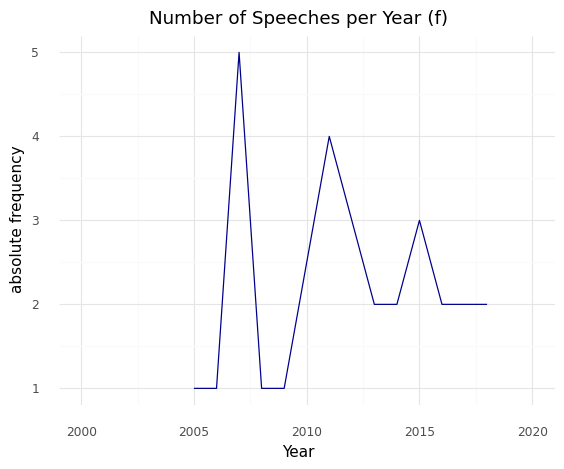

<ggplot: (8790088269234)>

In [11]:
docs_per_year = df_sub.groupby('Jahr').agg({'text': "count" }).reset_index().rename(columns={'text':'count'})

(ggplot(docs_per_year, aes(x='Jahr', y='count'))
 + geom_line(color='darkblue')
 +  labs(title = "Number of Speeches per Year (f)", x = "Year", y = "absolute frequency")
 + xlim(2000,2020)
 + scale_y_continuous(breaks=range(0, 11))
 + theme_minimal())

/home/nilsos/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 253 rows containing missing values.


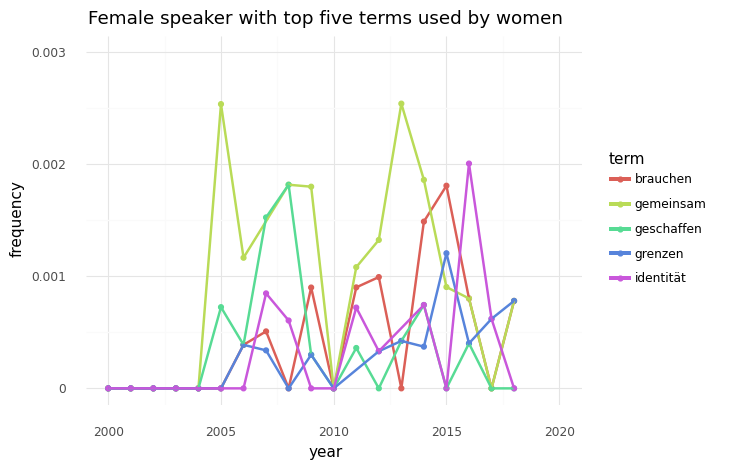

<ggplot: (8790085365986)>

In [12]:
# filter the dataset for the five most used terms in speeches read by a female speaker
terms = ["gemeinsam", "grenzen", "brauchen", "geschaffen", "identität"]
df_terms = df_tidy[df_tidy['term'].isin(terms)]

# plot the relative frequency for the terms above
(ggplot(df_terms, aes(x='year', y='frequency', color='term'))
 + ggtitle('Female speaker with top five terms used by women') # give plot a name to differentiate from male plot
 + geom_point() # show individual points
 + stat_smooth(method='lowess', span=0.15, se=False) # overlay points with a smoothed line
 + ylim(0,0.003)
 + xlim(2000,2020) # change x-axis numbers to match the data
 + theme_minimal()) # make the plot look nicer

/home/nilsos/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 200 rows containing missing values.


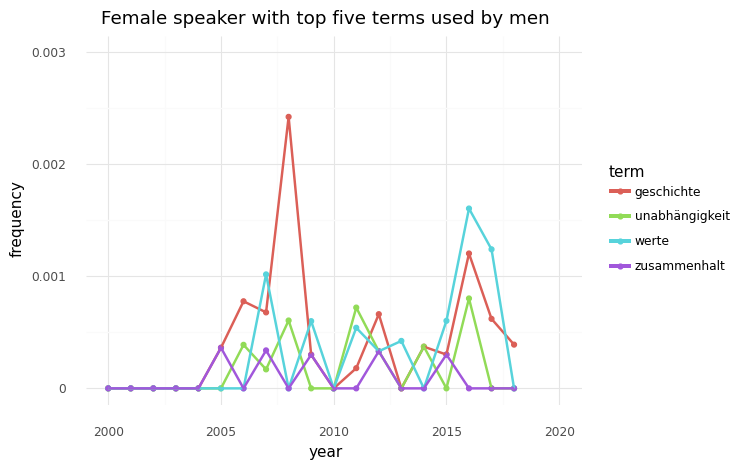

<ggplot: (8790084210463)>

In [13]:
# filter the dataset for the five most used terms in speeches read by a female speaker
terms = ["geschichte", "tessin", "unabhängigkeit", "werte", "zusammenhalt"]
df_terms = df_tidy[df_tidy['term'].isin(terms)]

# plot the relative frequency for the terms above
(ggplot(df_terms, aes(x='year', y='frequency', color='term'))
 + ggtitle('Female speaker with top five terms used by men') # give plot a name to differentiate from male plot
 + geom_point() # show individual points
 + stat_smooth(method='lowess', span=0.15, se=False) # overlay points with a smoothed line
 + ylim(0,0.003)
 + xlim(2000,2020) # change x-axis numbers to match the data
 + theme_minimal()) # make the plot look nicer